In [1]:
import pandas as pd
import numpy as np
from random import *
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, precision_score, recall_score

import my_pickle as mp
import my_features as mf
import my_resample as ms
# from my_resample import div_count_pos_neg, undersample, oversample
from sklearn.model_selection import GridSearchCV

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold
from sklearn.metrics import roc_curve, auc
from scipy import interp


from sklearn.linear_model import LogisticRegression

In [2]:
X = mp.unjson_it('data_features')
print("Make sure we're not using ECT data")
print(X.timestamp.max())
y = X.response
X = X.drop(['response','timestamp','len_sender','len_receiver'], axis=1)
X.head()

Make sure we're not using ECT data
2017-10-02 01:35:58.644000


,I_count_receiver,I_count_sender,I_ratio_receiver,I_ratio_sender,age_dif,age_receiver,age_sender,amenities_overlap,distance,exclaim_count_receiver,...,sentence_ratio_sender,smokingOk_receiver,smokingOk_sender,term_receiver,term_sender,type_receiver,type_sender,urgency,urgency_receiver,urgency_sender
100,2,3,0.005263,0.008772,9,32,23,0,0.552752,0,...,0.008772,0,0,NaN,12.0,NaN,1.0,NaN,NaN,1.010731e+09
10002,1,0,0.002227,NaN,5,31,26,0,0.068024,1,...,NaN,1,1,NaN,12.0,NaN,0.0,NaN,NaN,NaN
10003,3,0,0.015957,0.000000,7,20,27,3,NaN,0,...,0.000000,1,0,12.0,12.0,1.0,1.0,NaN,NaN,NaN
10008,1,8,0.014286,0.024768,0,25,25,1,0.092504,0,...,0.021672,1,1,24.0,12.0,1.0,NaN,6.556600e+09,6.556600e+09,2.181004e+09
10009,4,0,0.016000,NaN,1,21,20,2,0.113974,1,...,NaN,0,0,12.0,12.0,1.0,0.0,NaN,NaN,NaN


In [6]:
X = X.fillna(X.mean(axis=0))
X.head()

,I_count_receiver,I_count_sender,I_ratio_receiver,I_ratio_sender,age_dif,age_receiver,age_sender,amenities_overlap,distance,exclaim_count_receiver,...,sentence_ratio_sender,smokingOk_receiver,smokingOk_sender,term_receiver,term_sender,type_receiver,type_sender,urgency,urgency_receiver,urgency_sender
100,2,3,0.005263,0.008772,9,32,23,0,0.552752,0,...,0.008772,0,0,11.218629,12.0,0.908653,1.000000,2.980960e+09,2.980960e+09,1.010731e+09
10002,1,0,0.002227,0.012595,5,31,26,0,0.068024,1,...,0.018102,1,1,11.218629,12.0,0.908653,0.000000,2.980960e+09,2.980960e+09,-6.768931e+09
10003,3,0,0.015957,0.000000,7,20,27,3,9.291211,0,...,0.000000,1,0,12.000000,12.0,1.000000,1.000000,2.980960e+09,2.980960e+09,-6.768931e+09
10008,1,8,0.014286,0.024768,0,25,25,1,0.092504,0,...,0.021672,1,1,24.000000,12.0,1.000000,0.862843,6.556600e+09,6.556600e+09,2.181004e+09
10009,4,0,0.016000,0.012595,1,21,20,2,0.113974,1,...,0.018102,0,0,12.000000,12.0,1.000000,0.000000,2.980960e+09,2.980960e+09,-6.768931e+09


In [19]:
X.columns

Index(['I_count_receiver', 'I_count_sender', 'I_ratio_receiver',
       'I_ratio_sender', 'age_dif', 'age_receiver', 'age_sender',
       'amenities_overlap', 'exclaim_count_receiver', 'exclaim_count_sender',
       'exclaim_ratio_receiver', 'exclaim_ratio_sender', 'facebookId_receiver',
       'facebookId_sender', 'gender_receiver', 'gender_sender',
       'has_about_receiver', 'has_about_sender', 'has_room_receiver',
       'has_room_sender', 'hobbies_overlap', 'inRelationship_receiver',
       'inRelationship_sender', 'isClean_receiver', 'isClean_sender',
       'isNight_receiver', 'isNight_sender', 'isStudent_receiver',
       'isStudent_sender', 'len_about_receiver', 'len_about_sender',
       'len_sender', 'linkedinId_receiver', 'linkedinId_sender',
       'maxCost_receiver', 'maxCost_sender', 'minCost_receiver',
       'minCost_sender', 'numRoommates_receiver', 'numRoommates_sender',
       'onboarded_receiver', 'onboarded_sender', 'period_count_receiver',
       'period_count_s

In [3]:
def do_grid_search(X, y):
    '''
    X as 2d numpy array
    y as 1d numpy array
    
    PARAMETERS
    n_estimators: The number of trees in the forest
    criterion: gini or entropy
    max_features: The number of features to consider when looking for the best split
        If int, then consider max_features features at each split.
        If float, then max_features is a percentage and int(max_features * n_features) features are considered at each split.
        If “auto”, then max_features=sqrt(n_features).
        If “sqrt”, then max_features=sqrt(n_features) (same as “auto”).
        If “log2”, then max_features=log2(n_features).
        If None, then max_features=n_features.
    max_depth: The maximum depth of the tree
    n_jobs: The number of jobs to run in parallel for both fit and predict. If -1, then the number of jobs is set to the number of cores.
    '''
    
    # Split it up into our training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X, y)

    # resample
    X_train, y_train = ms.oversample(X_train.as_matrix(), y_train.as_matrix(), .5)
    
    # Initalize our model here
    model = RandomForestClassifier()

    # Here are the params we are tuning
    param_grid = {'max_features' : [None],
                  'n_estimators' : [50,100,1000],
                  'max_depth': [50],
                  'min_samples_leaf': [3]
                  }

    # Plug in our model, params dict, and the number of jobs, then .fit()
    gs_cv = GridSearchCV(model, param_grid, n_jobs=-1).fit(X_train, y_train)

    # return the best score and the best params
    return gs_cv.best_score_, gs_cv.best_params_

In [ ]:
%%time
n = do_grid_search(X, y)
print(n)

In [7]:
def fit_model(model, X, y):

    X_train, X_test, y_train, y_test = train_test_split(X.as_matrix(), y.as_matrix(), random_state=17)

    X_train, y_train = ms.undersample(X_train, y_train, .5)
    X_train, y_train = ms.oversample(X_train, y_train, .8)

    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    print("\nMETRICS")
    print("Model recall: {}".format(recall_score(y_test, y_pred)))
    print("Model precision: {}".format(precision_score(y_test, y_pred)))
    print("Model accuracy: {}".format(model.score(X_test, y_test)))

    pred_all_0 = [0]*len(y_test)
    pred_all_1 = [1]*len(y_test)
    pred_50_50 = np.random.choice([0,1], size=len(y_test))
    pred_90_10 = np.random.choice([0,1], size=len(y_test), p=[.9,.1])

    print ("\nCONFUSION MATRIX")
    print (confusion_matrix(y_test, y_pred))
    print ("\nkey:")
    print (" TN   FP ")
    print (" FN   TP ")

    try:
#         print(model.feature_importances_)

        feature_importances = np.argsort(model.feature_importances_)
        top_n = len(X.columns)
        print("\nFEATURE RANKINGS")
        for n in range(top_n):
            print(n+1, '\t',X.columns[feature_importances[-n-1]], '\t',sorted(model.feature_importances_)[-n-1])
    except:
        pass
    # TO DOUBLE CHECK STUFF:    
    # for n in range(top_n):   
    #     print(model.feature_importances_[n], X.columns[n])

    print("\nRECALL AND ACCURACY FOR DIFFERNET MODELS")
    print("recall     \t precision   \tmodel")
    print(recall_score(y_test, y_pred), '\t',precision_score(y_test, y_pred), "my model")
    print(recall_score(y_test, pred_all_0),'\t','\t', precision_score(y_test, pred_all_0), "\t\tpredict all zero")
    print(recall_score(y_test, pred_all_1),'\t','\t', precision_score(y_test, pred_all_1), "predict all one")
    print(recall_score(y_test, pred_50_50),'\t', precision_score(y_test, pred_50_50), "predict 50-50")
    print(recall_score(y_test, pred_90_10), precision_score(y_test, pred_90_10), "predict 90-10")

In [11]:
%%time
model = RandomForestClassifier(max_depth=50, max_features=None, min_samples_leaf=3, n_estimators=100, n_jobs=-1)
fit_model(model, X, y)


METRICS
Model recall: 0.8528301886792453
Model precision: 0.13899138991389914
Model accuracy: 0.4738574040219378

CONFUSION MATRIX
[[1070 1400]
 [  39  226]]

key:
 TN   FP 
 FN   TP 

FEATURE RANKINGS
1 	 distance 	 0.0894536724312
2 	 len_about_receiver 	 0.0664530255563
3 	 age_receiver 	 0.042713044086
4 	 maxCost_sender 	 0.0393845178109
5 	 age_sender 	 0.0331825471368
6 	 age_dif 	 0.0324431794354
7 	 maxCost_receiver 	 0.0306300901093
8 	 I_ratio_sender 	 0.0298473200383
9 	 hobbies_overlap 	 0.0272320684341
10 	 minCost_receiver 	 0.025434019673
11 	 term_sender 	 0.0253938451057
12 	 rent_overlap 	 0.0245967730095
13 	 sentence_ratio_sender 	 0.0227269800216
14 	 urgency_sender 	 0.0221843477709
15 	 numRoommates_receiver 	 0.0220916760993
16 	 minCost_sender 	 0.0208969238134
17 	 numRoommates_sender 	 0.0204314645066
18 	 term_receiver 	 0.0198589517844
19 	 period_ratio_sender 	 0.0193822314528
20 	 I_ratio_receiver 	 0.0183940511979
21 	 len_about_sender 	 0.018333881465

/Users/gandalf/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


In [9]:
%%time
model = LogisticRegression()
fit_model(model, X, y)


METRICS
Model recall: 0.8830188679245283
Model precision: 0.09562729873314263
Model accuracy: 0.17952468007312614

CONFUSION MATRIX
[[ 257 2213]
 [  31  234]]

key:
 TN   FP 
 FN   TP 

RECALL AND ACCURACY FOR DIFFERNET MODELS
recall     	 precision   	model
0.883018867925 	 0.0956272987331 my model
0.0 	 	 0.0 		predict all zero
1.0 	 	 0.0968921389397 predict all one
0.48679245283 	 0.0915542938254 predict 50-50
0.0830188679245 0.0805860805861 predict 90-10
CPU times: user 252 ms, sys: 69.3 ms, total: 321 ms
Wall time: 415 ms


/Users/gandalf/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


In [ ]:

print ("    Decision Tree:       ", get_scores(DecisionTreeClassifier, X_train, X_test, y_train, y_test))
print ("    Naive Bayes:         ", get_scores(MultinomialNB, X_train, X_test, y_train, y_test))

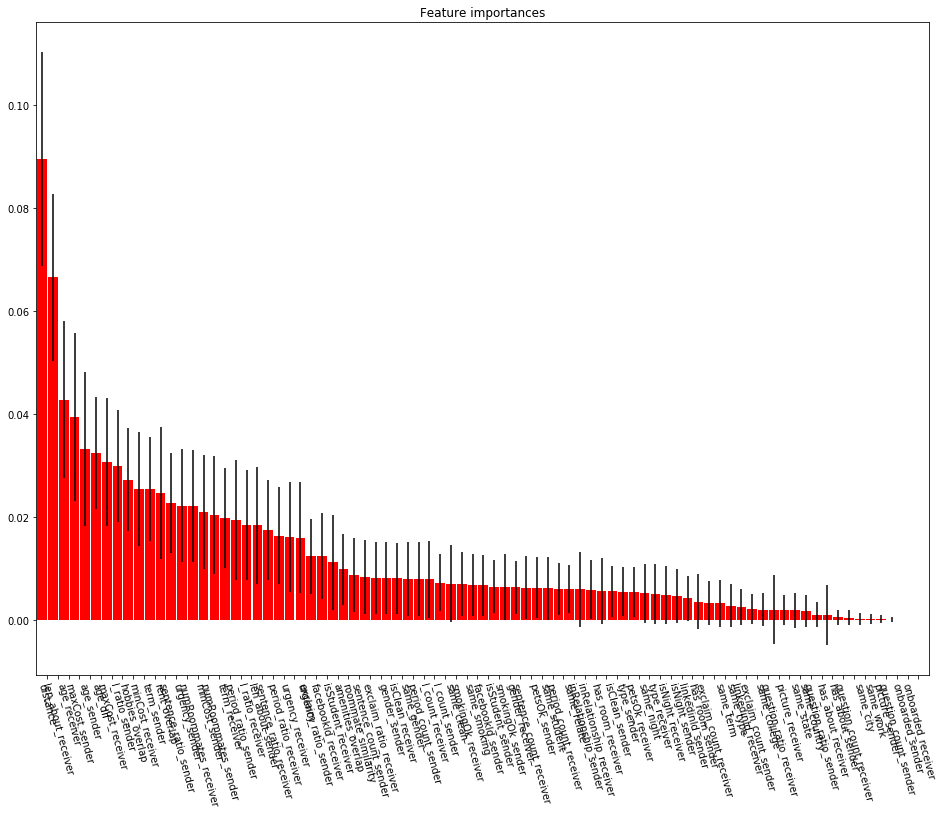

In [12]:
# Calculate the standard deviation for feature importances across all trees

n = len(X.columns)

#importances = forest_fit.feature_importances_[:n]
importances = model.feature_importances_[:n]
std = np.std([tree.feature_importances_ for tree in model.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1]
features = list(X.columns[indices])

# print("Feature ranking:")
# for f in range(n):
#     print("%d. %s (%f)" % (f + 1, features[f], importances[indices[f]]))

# Plot the feature importances of the forest
plt.figure(figsize=(16,12))
plt.title("Feature importances")
plt.bar(range(n), importances[indices], yerr=std[indices], color="r", align="edge", width = -.9)
plt.xticks(range(n), features, rotation=-75)
plt.xlim([-1, n])
plt.show()

In [ ]:
# Try modifying the number of trees, graph results
num_trees = range(5, 50, 5)
accuracies = []
for n in num_trees:
    tot = 0
    for i in range(5):
        rf = RandomForestClassifier(n_estimators=n)
        rf.fit(X_train, y_train)
        tot += rf.score(X_test, y_test)
    accuracies.append(tot / 5)
plt.plot(num_trees, accuracies)
plt.xlabel="num_trees"
plt.ylabel="accuracy"
plt.show()

In [ ]:
# Modifying the max features parameter
for nn in range(10):
    num_features = range(2, len(X.columns))
    accuracies = []
    for n in num_features:
        tot = 0
        for i in range(5):
            rf = RandomForestClassifier(max_features=n)
            rf.fit(X_train, y_train)
            tot += rf.score(X_test, y_test)
        accuracies.append(tot / 5)
    plt.plot(num_features, accuracies)
    plt.xlabel="num_features"
    plt.ylabel="accuracy"
plt.show()

In [ ]:
# Run all the other classifiers that we have learned so far in class
def get_scores(classifier, X_train, X_test, y_train, y_test, **kwargs):
    model = classifier(**kwargs)
    model.fit(X_train, y_train)
    y_predict = model.predict(X_test)
    return model.score(X_test, y_test), \
           precision_score(y_test, y_predict), \
           recall_score(y_test, y_predict)

print ("    Model,                Accuracy, Precision, Recall")
print ("    Random Forest:       ", get_scores(RandomForestClassifier, X_train, X_test, y_train, y_test, n_estimators=25, max_features=5))
print ("    Logistic Regression: ", get_scores(LogisticRegression, X_train, X_test, y_train, y_test))
print ("    Decision Tree:       ", get_scores(DecisionTreeClassifier, X_train, X_test, y_train, y_test))
print ("    Naive Bayes:         ", get_scores(MultinomialNB, X_train, X_test, y_train, y_test))

In [ ]:
def plot_roc(X, y, clf_class, title, **kwargs):
# def plot_roc(X, y, clf_class, kwargs):
    scaler = StandardScaler()
    X = scaler.fit_transform(X)
    kf = KFold(len(y), n_folds=5, shuffle=True)
    y_prob = np.zeros((len(y),2))
    mean_tpr = 0.0
    mean_fpr = np.linspace(0, 1, 100)
    all_tpr = []
    for i, (train_index, test_index) in enumerate(kf):
        X_train, X_test = X[train_index], X[test_index]
        y_train = y[train_index]
        clf = clf_class(**kwargs)
        clf.fit(X_train,y_train)
        # Predict probabilities, not classes
        y_prob[test_index] = clf.predict_proba(X_test)
        fpr, tpr, thresholds = roc_curve(y[test_index], y_prob[test_index, 1])
        mean_tpr += interp(mean_fpr, fpr, tpr)
        mean_tpr[0] = 0.0
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, lw=1, label='ROC fold %d (area = %0.2f)' % (i, roc_auc))
    mean_tpr /= len(kf)
    mean_tpr[-1] = 1.0
    mean_auc = auc(mean_fpr, mean_tpr)
    plt.plot(mean_fpr, mean_tpr, 'k--',label='Mean ROC (area = %0.2f)' % mean_auc, lw=2)

    plt.plot([0, 1], [0, 1], '--', color=(0.6, 0.6, 0.6), label='Random')
    plt.xlim([-0.05, 1.05])
    plt.ylim([-0.05, 1.05])
#     plt.xlabel('False Positive Rate')
#     plt.ylabel('True Positive Rate')
    plt.title(title + 'ROC')
    plt.legend(loc="lower right")
    plt.show()

In [ ]:
xfake, yfake = np.random.rand(100,6), np.random.randint(0,2, size=(100,))
plt.figure(figsize=(20,16))
print ("Visualize the roc curve of each model")
plot_roc(xfake, yfake, RandomForestClassifier, 'Random_Forest', n_estimators=25, max_features=5)
#plot_roc(X, y, LogisticRegression, 'Logistic_Regrssion')
#plot_roc(X, y, DecisionTreeClassifier, 'Decision_Tree')
#plot_roc(X, y, MultinomialNB, 'Naive_Bayes') error
print('\nPlotting completed.')

In [ ]:
print ("Visualize the roc curve of each model")
plot_roc(X, y, RandomForestClassifier, 'Random_Forest', n_estimators=25, max_features=5)
plot_roc(X, y, LogisticRegression, 'Logistic_Regrssion')
plot_roc(X, y, DecisionTreeClassifier, 'Decision_Tree')
#plot_roc(X, y, MultinomialNB, 'Naive_Bayes') error
print('\nPlotting completed.')